In this Colab, We will learn how to use `TensorFlow Hub` and the concept of ` Transfer Learning ` to train new dataset using a pre-trained model.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In [1]:
#Importing external libraries
import tensorflow as tf


In [2]:
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In this Colab, we will be using MobileNet V2, load it into keras and try it out.

We can also use any other model from tf2 compatible classifier URL tfhub.dev

### Downloading the classifier


Downloading the MobileNet model and creatinh a keras model from it.
The MobileNet Model is trained on ImageNet dataset that comprises of 1000 classes and RGB Images of 224 * 224 pixel size.

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Running it one a single Image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. We will get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

61306/61306 [==============================] - 0s 0us/step


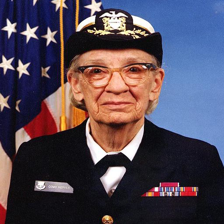

In [5]:
# Import supporting external libraries
import numpy as np
import PIL.Image as Image

mil_uni = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
mil_uni = Image.open(mil_uni).resize((IMAGE_RES, IMAGE_RES))
mil_uni

In [6]:
mil_uni = np.array(mil_uni)/255.0
mil_uni.shape

(224, 224, 3)

In [7]:
'''
IMPORTANT NOTE
models always want a batch of images to process.
So here, we add a batch dimension, and pass the image to the model for prediction.
'''
result = model.predict(mil_uni[np.newaxis, ... ])
result.shape

1/1 [==============================] - 1s 852ms/step


(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decoding our Prediction of Single Image
To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

10484/10484 [==============================] - 0s 0us/step


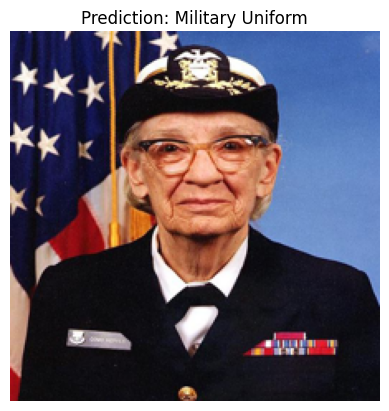

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(mil_uni)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Clearly, the model correctly predicted our image.

### Use a TensorFlow Hub models for the Cats vs. Dogs dataset

In [10]:
# Using Tensorflow Datasets to load Dogs and Cats Dataset

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteWJXOES/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
# Checcking the size of images of dogs and cats
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


## Reformatting the Images
Since the size of all images in the Dogs vs. Cats dataset are differnet. There is a need to reformat the image sizes to match the resolution of the pre-trained model.

We need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.


In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 952ms/step


array(['bluetick', 'redbone', 'tabby', 'kelpie', 'Egyptian cat',
       'Chihuahua', 'Walker hound', 'lynx', 'tabby', 'tabby',
       'German short-haired pointer', 'Persian cat', 'Egyptian cat',
       'groenendael', 'Egyptian cat', 'Persian cat', 'chow', 'tiger cat',
       'miniature poodle', 'vizsla', 'mouse', 'Rottweiler', 'Boston bull',
       'Walker hound', 'tabby', 'Persian cat', 'tabby', 'beagle', 'tabby',
       'German shepherd', 'Persian cat', 'Egyptian cat'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

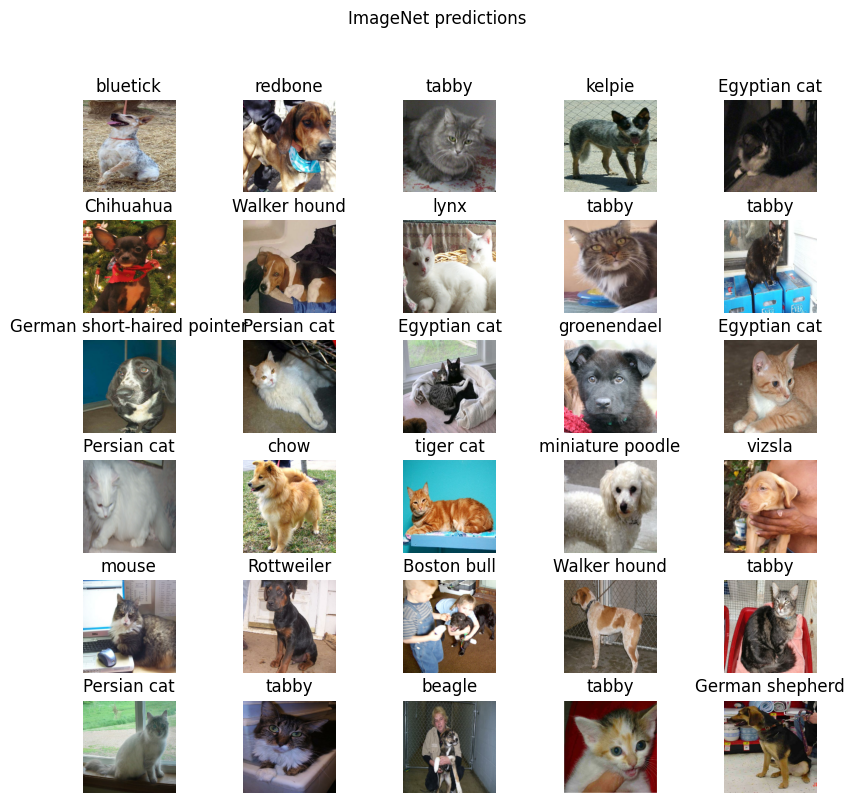

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Performing Simple Transfer Learning

We will be using TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning.


Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


### Freezing the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [17]:
feature_extractor.trainable = False

### Wrapping the hub layer to include Sequential Model and adding Classification Layer

In [18]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
# Training the model

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 4
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/4
582/582 [==============================] - 1003s 2s/step - loss: 0.0375 - accuracy: 0.9866 - val_loss: 0.0325 - val_accuracy: 0.9895
Epoch 2/4
582/582 [==============================] - 983s 2s/step - loss: 0.0273 - accuracy: 0.9908 - val_loss: 0.0307 - val_accuracy: 0.9897
Epoch 3/4
582/582 [==============================] - 900s 2s/step - loss: 0.0227 - accuracy: 0.9920 - val_loss: 0.0323 - val_accuracy: 0.9893
Epoch 4/4
582/582 [==============================] - 987s 2s/step - loss: 0.0196 - accuracy: 0.9935 - val_loss: 0.0387 - val_accuracy: 0.9890


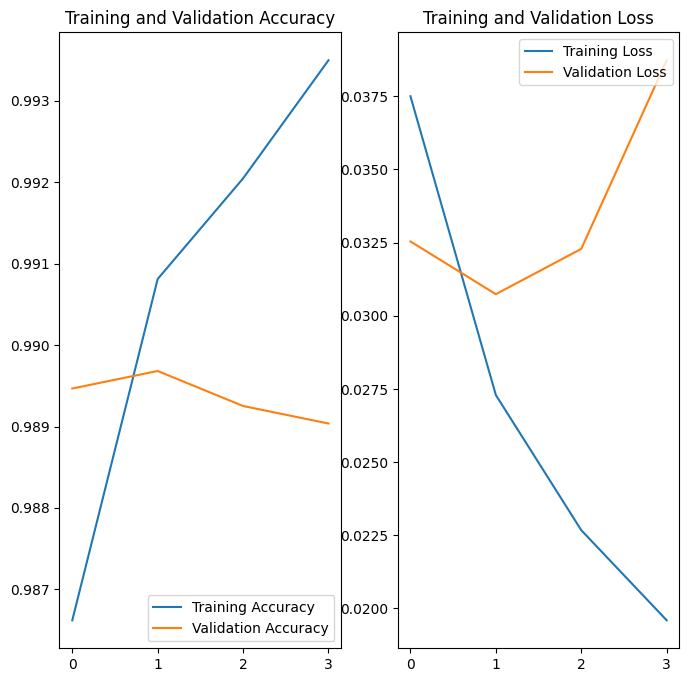

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can clearly see that the validation accuracy has increased
which is a major upgrade from the validation accuracy we achieved using Image Augmentation and Dropout techniques.

It is surprising to see that the validation accuracy is better than training performance, right from the beginning to the end of execution.

This trend is seen because validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Checking Predictions

In [22]:
# To red-do a plot, we get an ordered list of class names

class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Running the image batch through the model and convert the indices to class names

In [23]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat',
       'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat',
       'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [24]:
# Looking at Labels and Predicted Labels
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0]
Predicted labels:  [1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0]


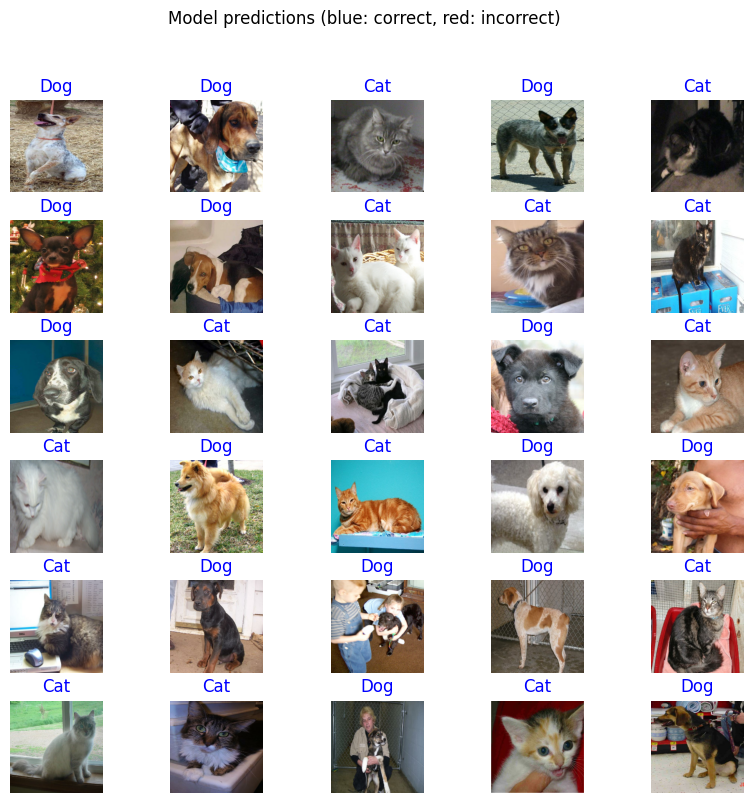

In [25]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")